In [1]:
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
df = pd.read_csv('../data/coin_metadata.csv')

In [5]:
constantine_df = df[df.portrait=='Constantine I']

In [6]:
augustus_df = df[df.portrait=='Augustus']

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
print(tf.__version__)
print(tf.keras.__version__)

2.2.0
2.3.0-tf


In [9]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [10]:
df.columns

Index(['Unnamed: 0', 'authority', 'portrait', 'year', 'obj', 'denomination',
       'material', 'region', 'deity', 'url', 'fname'],
      dtype='object')

In [11]:
frames = [constantine_df,augustus_df]

demo_df = pd.concat(frames).reset_index(drop=True)

In [12]:
demo_df.drop('Unnamed: 0',axis=1,inplace=True)

In [13]:
from sklearn.model_selection import train_test_split

X = demo_df.drop('portrait',axis=1)

y = demo_df.portrait

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [14]:
file_path = f'../imgs/'

In [15]:
raw_image = tf.io.read_file(file_path+'Augustus_Augustus_1590971956.7459717'+'.jpg')
image = tf.image.decode_jpeg(raw_image, channels=3)

In [16]:
image.shape

TensorShape([173, 175, 3])

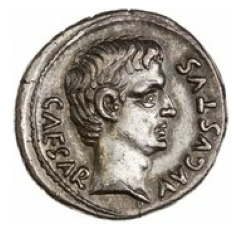

In [17]:
plt.imshow(image)
plt.grid(False)
plt.xticks([])
_ = plt.yticks([])

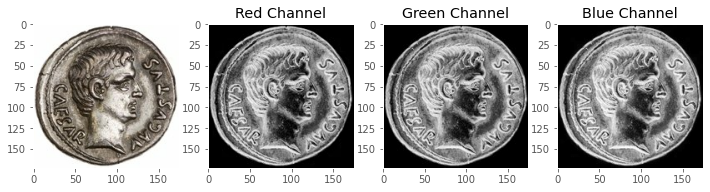

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs[0].imshow(image)
axs[0].grid(False)
for i in range(1, 4):
    axs[i].imshow(image[:, :, i-1], cmap=plt.cm.gray_r)
    axs[i].set_title("{} Channel".format(["Red", "Green", "Blue"][i-1]))

remove_grid_lines(axs)

In [19]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

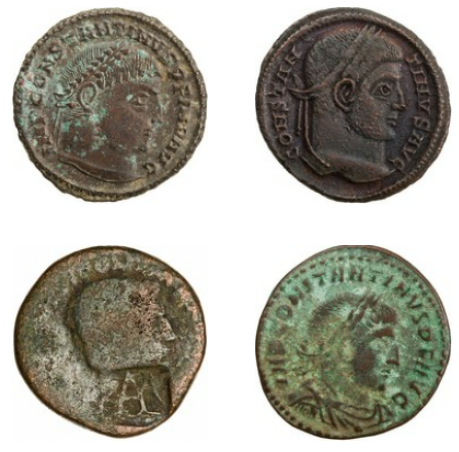

In [20]:
# The number of flower images:
n_flower_images = 1360

# The format specification here left pads zeros on the number: 0004.
coin_filenames = [file_path + f'{fname}.jpg' for fname in X_train.fname]

## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(coin_filenames)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

## Finding and deleting corrupted images that Tensorflow cannot handle

In [21]:
training_imgs = []
for filename in coin_filenames:
    try:
        img = load_and_preprocess_image(filename)
        training_imgs.append(img)
    except:        
        print(filename)

../imgs/Constantine I_Constantine I_1590975007.3262157.jpg
../imgs/Constantine I_Constantine I_1590974986.5141442.jpg
../imgs/Constantine I_Constantine I_1590975007.606479.jpg
../imgs/Constantine I_Constantine I_1590974986.1981895.jpg


In [ ]:
# for i in sorted(del_list,reverse=True):
#     print(i)
#     del coin_filenames[i]

In [29]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    return image

#try_filenames = coin_filenames[:10]

training_imgs = []

for filename in coin_filenames:
    try:
        img = load_and_preprocess_image(filename)
        training_imgs.append(np.asarray(img))
    except:        
        print(filename)
        
training_materials = np.asarray(training_imgs)

../imgs/Constantine I_Constantine I_1590975007.3262157.jpg
../imgs/Constantine I_Constantine I_1590974986.5141442.jpg
../imgs/Constantine I_Constantine I_1590975007.606479.jpg
../imgs/Constantine I_Constantine I_1590974986.1981895.jpg


In [ ]:
#print(len(training_imgs))

In [ ]:
#train_images = np.asarray(training_imgs)

## Training the tensorflow model

In [ ]:
#train_imgs = np.asarray([load_and_preprocess_image(coin_filename) for coin_filename in coin_filenames])
#[load_and_preprocess_image(coin_filename) for coin_filename in coin_filenames]

In [24]:
# model = keras.Sequential()
# ## unstacking rows of pixels in the image and lining them up
# model.add(keras.layers.Flatten(input_shape=(192,192,3)))

# ## The second (and last) layer is a 10-node softmax layer that 
# ##    returns an array of 10 probability scores that sum to 1

# model.add(keras.layers.Dense(10, activation='softmax'))

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(192,192,3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 110592)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               14155904  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 14,157,194
Trainable params: 14,157,194
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
np.array(y_train)

In [ ]:
model.fit(, np.array(y_train), epochs=10)

In [ ]:
np.asarray([val for val in y_train.values])